# Variational Auto-Encoder

### Sources

##### VAE Specific

https://debuggercafe.com/convolutional-variational-autoencoder-in-pytorch-on-mnist-dataset/

https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/

https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd


##### CNN in General

Testing/Validation: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_solution.ipynb

Theory: https://cs231n.github.io/convolutional-networks/#conv

Theory/AE Class: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/convolutional-autoencoder/Convolutional_Autoencoder_Solution.ipynb

Theory/AE Class: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_solution.ipynb

### Imports

In [ ]:
import numpy as np
import pandas as pd
import datetime
import os
from collections import OrderedDict
from pathlib import Path
import uuid
#import pydicom
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Import essential libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
#from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import gzip

### Data Preparation

In [2]:
cxr_root_path = "/media/Data/ComputerVision/mimic_cxr_jpg_small_chest_radiograph/data/physionet.org/files/mimic-cxr-jpg/2.0.0/"
record_df = pd.read_csv('{}/cxr-record-list.csv.gz'.format(cxr_root_path), sep=',')
record_df.head()

,subject_id,study_id,dicom_id,path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...


In [3]:
df_split = pd.read_csv('{}/mimic-cxr-2.0.0-split.csv.gz'.format(cxr_root_path))
dataset = df_split.merge(record_df, on=['subject_id', 'study_id', 'dicom_id'], how='left')
num_images=len(dataset)
print(num_images)

377110


### Selecting Portion of Data

In [4]:
dataset=dataset[0:10000]

### Selecting Device

In [5]:
import torch.optim as optim
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device='cpu'
print(device)

cuda


In [6]:
class CustomDatasetFromImages(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms=None): 
        self.dataframe = dataframe
        self.transforms = transforms
    def __getitem__(self, index):
        imagepath=self.dataframe["path"].iloc[index]
        imagepath=cxr_root_path+imagepath[:-4]+'.jpg'
        image=Image.open(imagepath)
        if self.transforms is not None:
            image=self.transforms(image)
        return image
    def __len__(self):
        return len(self.dataframe)

In [7]:
train_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.RandomRotation((-20, 20)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                            torchvision.transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images])
test_Aug = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                          torchvision.transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])])  # for grayscale images])

In [8]:
train_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='train'], transforms=train_Aug)
test_set=CustomDatasetFromImages(dataset.loc[dataset['split']=='validate'], transforms=test_Aug)
trainloader= torch.utils.data.DataLoader(train_set, batch_size=64, num_workers=2,shuffle=True) 
testloader= torch.utils.data.DataLoader(test_set, batch_size=64, num_workers=2,shuffle=False)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable


class ResNet_VAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256,model_name='resnet50'):
        super(ResNet_VAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim
        
        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet50(pretrained=False)
        #resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               #bias=False)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_modules=modules
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.fc4(z)
        x = self.relu(self.fc_bn4(x))
        x = self.fc5(x)
        x = self.relu(self.fc_bn5(x)).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)
        return x_reconst, z, mu, logvar

In [10]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 1024
CNN_embed_dim = 256     # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.2       # dropout probability


In [ ]:
model = ResNet_VAE(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

### Loss Function

In [ ]:
def vae_loss_function(recon_x, x, mu, logvar):
    # MSE = F.mse_loss(recon_x, x, reduction='sum')
    MSE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [ ]:
learning_rate = 1e-3

In [ ]:
# number of epochs to train the model
torch.cuda.empty_cache()
n_epochs = 5

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model=ResNet_VAE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.BCELoss(reduction='sum')

### Training and Validation

In [35]:
valid_loss_min = np.Inf # track change in validation loss
train_loss_list=[]
valid_loss_list=[]
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    epoch_losses=[]
    model.train()
    epoch_loss=0
    for data in trainloader: 
        batch_size, _, _, _ = data.shape
        optimizer.zero_grad()
        data=data.to(device)
        X_reconst, z, mu, logvar = model(data)  # VAE
        loss = vae_loss_function(X_reconst, data.to(device), mu, logvar)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        #print("Batch loss: ",loss)
        
        
    # validate the model #
    model.eval()
    for data in testloader:
        # move tensors to GPU if CUDA is available
        # forward pass: compute predicted outputs by passing inputs to the model
        data=data.to(device)
        X_reconst, z, mu, logvar = model(data)
        loss = vae_loss_function(X_reconst, data.to(device), mu, logvar)
        # update average validation loss 
        valid_loss += loss.item()
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(testloader.sampler)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        #torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 96232.089414 	Validation Loss: 101564.595562
Validation loss decreased (inf --> 101564.595562).  Saving model ...
Epoch: 2 	Training Loss: 83660.796301 	Validation Loss: 88122.643569
Validation loss decreased (101564.595562 --> 88122.643569).  Saving model ...
Epoch: 3 	Training Loss: 80414.290596 	Validation Loss: 84779.405344
Validation loss decreased (88122.643569 --> 84779.405344).  Saving model ...
Epoch: 4 	Training Loss: 78737.287003 	Validation Loss: 81024.647645
Validation loss decreased (84779.405344 --> 81024.647645).  Saving model ...
Epoch: 5 	Training Loss: 77846.508387 	Validation Loss: 80510.262228
Validation loss decreased (81024.647645 --> 80510.262228).  Saving model ...


### Plotting Loss Function across epochs

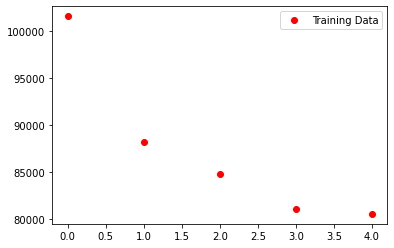

In [36]:
#print(train_loss_list[0])
#plt.plot(range(5),train_loss_list,'bo')
plt.plot(range(n_epochs),valid_loss_list,'ro')
plt.legend(['Training Data','Validation Data'])
plt.show()

### Plotting validation results

torch.Size([64, 3, 224, 224])
[64, 64, 64, 64]


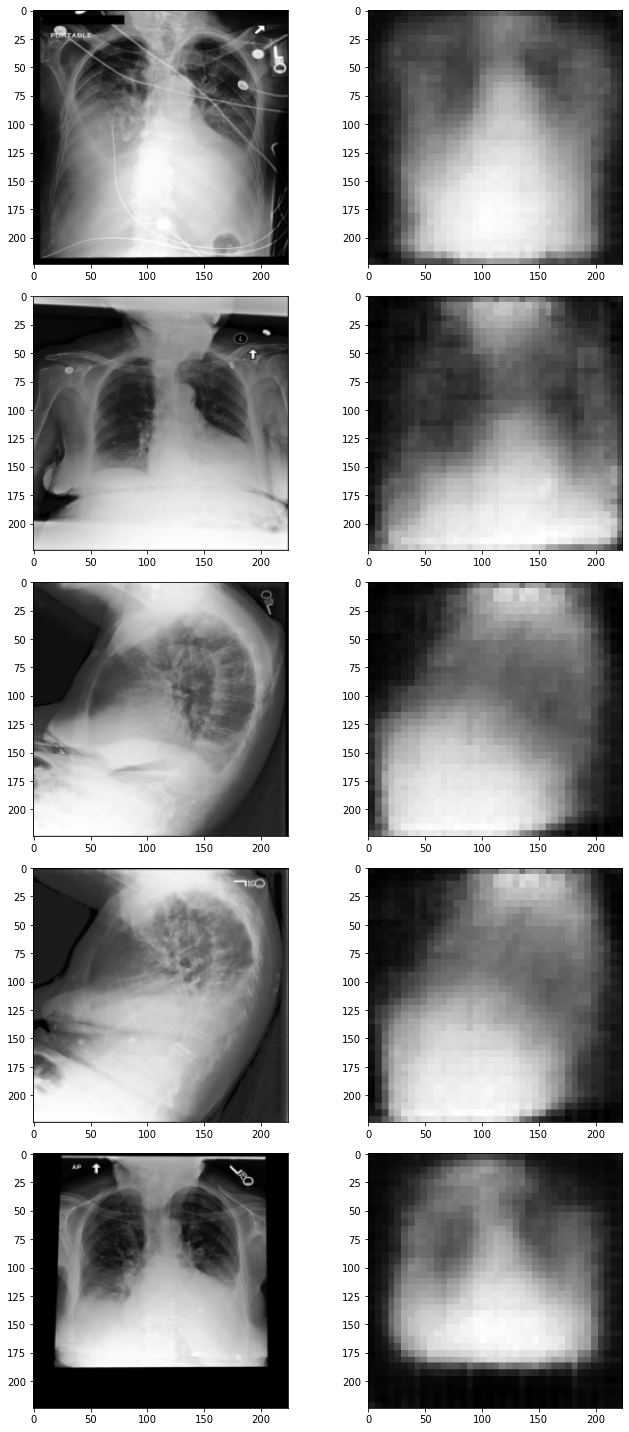

In [39]:
with torch.no_grad():
    # obtain one batch of test images
    dataiter = iter(testloader)
    images= dataiter.next()
    images.numpy()
    print(images.shape)
    # move model inputs to cuda, if GPU available
    #images = images.cuda()

    # get sample outputs
    output = model(images)
    print([len(a) for a in output])
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 20))
    for idx in range(5):
        ax = fig.add_subplot(5,2, 1+2*idx)
        im=np.reshape(images[idx][0],(224,224))
        ax.imshow(im,cmap='gray')
        ax2 = fig.add_subplot(5,2, 2+2*idx)
        im2=np.reshape(output[0][idx][0],(224,224)) #first index is index of return arguments in VAE class. second index is the image
        #in line above, try to see results with 3rd index =0, or without accessing that one specifically(in latter case, add 3 to reshape 3rd dimension).
        #in my experience, got repeated image for latter case, but got smthg else for latter
        ax2.imshow(im2,cmap='gray')
    fig.tight_layout()

torch.Size([64, 3, 224, 224])
[64, 64, 64, 64]


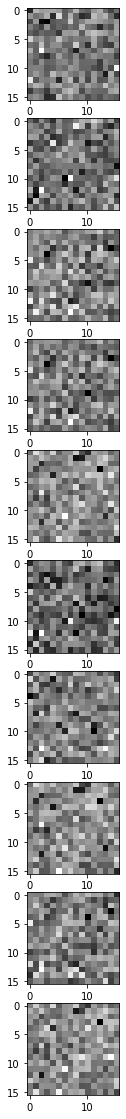

In [40]:
with torch.no_grad():
    # obtain one batch of test images
    dataiter = iter(testloader)
    images= dataiter.next()
    images.numpy()
    print(images.shape)
    # move model inputs to cuda, if GPU available
    #images = images.cuda()

    # get sample outputs
    output = model(images)
    print([len(a) for a in output])
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 20))
    for idx2 in range(10):
        ax3 = fig.add_subplot(10,1, 1+idx2)
        im3=np.reshape(output[1][idx2],(16,16)) #this is 2nd argument in returns of vae class, should be latent space
        ax3.imshow(im3,cmap='gray') 